In [1]:
import pandas as pd 
import numpy as np 
from matplotlib_venn import venn2 
import matplotlib.pyplot as plt 
import os 
import math

In [2]:
tshark_directory = os.path.join('.', 'traffictracer') 
statistic_directory = ['WLAN_statistics', 'Meta_statistics'] 
ori_directory = ['WLAN', 'Meta'] 
port_directory = 'tshark_port' 
conn_directory = 'conn_in_out' 
evaluation_directory = 'evaluation' 
data_date = '24-11-07' 

activities = ['video', 'audio', 'upload', 'download', 'streaming', 'email'] 

meta_prefix = 'Meta-' 
wlan_prefix = 'WLAN-' 
conn_prefix = 'conn-in-out-' 

chrome_blue  = '#4285f4' 
chrome_red = '#ea4335' 
chrome_green = '#34a853' 
chrome_yellow = '#fbbc05' 

In [3]:
meta_time_directory = os.path.join(tshark_directory, evaluation_directory, 'tt_fr', 'time_distribution', 'Meta') 
wlan_time_path = os.path.join(tshark_directory, evaluation_directory, 'tt_fr', 'time_distribution', 'WLAN') 

In [4]:
test_meta_time = os.path.join(tshark_directory, evaluation_directory, 'tt_fr', 'time_distribution', 'Meta', 'Meta-24-11-07--10-19-16.csv') 
test_wlan_time = os.path.join(tshark_directory, evaluation_directory, 'tt_fr', 'time_distribution', 'WLAN', 'WLAN-24-11-07--10-19-16.csv') 
test_conn = os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'conn_sni', 'conn-in-out-24-11-07--10-19-16.csv') 

In [9]:
bias = 1

def ori_position(r_tt, c_tt, r_ori, c_ori, number): 
    x_positions = [] 
    y_positions = [] 
    while len(x_positions) < number: 
        x = np.random.uniform(-r_tt, r_tt) 
        y = np.random.uniform(-r_tt, r_tt) 
        if (c_ori[0] - x)**2 + (c_ori[1] - y)**2 < (r_ori**2 - bias):
            x_positions.append(x)
            y_positions.append(y) 

    return x_positions, y_positions 

def tt_position(r_tt, c_tt, r_ori, c_ori, number): 
    x_positions = [] 
    y_positions = [] 
    while len(x_positions) < number: 
        x = np.random.uniform(-r_tt, r_tt) 
        y = np.random.uniform(-r_tt, r_tt) 
        if (c_ori[0] - x)**2 + (c_ori[1] - y)**2 > (r_ori**2 + bias) and (c_tt[0] - x)**2 + (c_tt[1] - y)**2 < (r_tt**2 - bias):
            x_positions.append(x)
            y_positions.append(y) 

    return x_positions, y_positions 

def drawVenn(number_ori, number_tt, number_main, output_path): 
    r1 = 4
    c1 = (0, 0)
    r2 = 4 - 0.5 * math.sqrt(2)
    c2 = (-0.5, 0.5)

    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(4, 4))
    # plt.figure()

    circle_tt = plt.Circle(c1, r1, edgecolor=chrome_blue, facecolor=chrome_blue, linewidth=2)
    ax.add_patch(circle_tt)

    circle_ori = plt.Circle(c2, r2, edgecolor=chrome_yellow, facecolor=chrome_yellow, linewidth=2)
    ax.add_patch(circle_ori)

    x_ori_position, y_ori_position = ori_position(r1, c1, r2, c2, number_ori) 
    x_tt_position, y_tt_position = tt_position(r1, c1, r2, c2, number_tt - number_ori)

    ax.scatter(x_ori_position[:number_main], y_ori_position[:number_main], marker='x', color='black', linewidths=1.5, s=50)
    ax.scatter(x_ori_position[number_main:], y_ori_position[number_main:], marker='x', color='black', linewidths=0.5, s=50) 
    ax.scatter(x_tt_position, y_tt_position, marker='x', color='black', linewidths=0.5, s=50)

    # 设置轴的比例和范围
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.axis('off')
    # 显示图形
    # plt.grid(True)
    plt.savefig(output_path, format='pdf') 
    plt.close(fig)
    plt.show()

In [6]:
def findActiveStreams(df_test_meta_time: pd.DataFrame, df_test_wlan_time: pd.DataFrame, df_test_conn:pd.DataFrame): 
    max_si = df_test_conn.loc[df_test_conn['W Flows'].idxmax()] 
    si_meta_id = max_si['M Stream ID']  
    si_wlan_id = max_si['W Stream ID'] 
    w_i = max_si['W Duration'] 
    filter_1 = df_test_conn.loc[(df_test_conn['W Duration'] >= w_i - 2) & (df_test_conn['W Duration'] <= w_i)] 
    min_sj = df_test_conn.loc[df_test_conn['W Flows'].idxmin()] 
    sj_meta_id = min_sj['M Stream ID'] 
    sj_wlan_id = min_sj['W Stream ID'] 
    si_meta_td = df_test_meta_time.loc[df_test_meta_time['StreamID'] == si_meta_id] 
    si_wlan_td = df_test_wlan_time.loc[df_test_wlan_time['StreamID'] == si_wlan_id] 
    sj_meta_td = df_test_meta_time.loc[df_test_meta_time['StreamID'] == sj_meta_id] 
    sj_wlan_td = df_test_wlan_time.loc[df_test_wlan_time['StreamID'] == sj_wlan_id] 
    return si_meta_td, si_wlan_td, sj_meta_td, sj_wlan_td 

In [7]:
def drawFig(si_meta_td: pd.DataFrame, si_wlan_td: pd.DataFrame, sj_meta_td: pd.DataFrame, sj_wlan_td: pd.DataFrame, output_path: str): 
    plt.figure(figsize=(4, 3))
    plt.rcParams['font.family'] = 'Microsoft YaHei'
    
    bins = 20
    time_bins_meta = pd.cut(si_meta_td['Time'], bins=bins) 
    time_bins_wlan = pd.cut(si_wlan_td['Time'], bins=bins)
    time_bins_sj_meta = pd.cut(sj_meta_td['Time'], bins=bins) 
    time_bins_sj_wlan = pd.cut(sj_wlan_td['Time'], bins=bins) 
    
    counts_meta = time_bins_meta.value_counts(sort=False) 
    counts_wlan = time_bins_wlan.value_counts(sort=False) 
    counts_meta_sj = time_bins_sj_meta.value_counts(sort=False) 
    counts_wlan_sj = time_bins_sj_wlan.value_counts(sort=False) 
    bin_centers = counts_meta.index.map(lambda interval: interval.mid) 
    
    # 绘制折线图 
    plt.plot(bin_centers, counts_meta.values, marker='o', label='MAS Before', color=chrome_blue, alpha=0.8) 
    plt.plot(bin_centers, counts_wlan.values, marker='*', label='MAS After', color=chrome_red, alpha=0.8) 
    plt.plot(bin_centers, counts_meta_sj.values, marker = 'o', label='LAS Before', color=chrome_yellow, alpha=0.8) 
    plt.plot(bin_centers, counts_wlan_sj.values, marker = '*', label='LAS After', color=chrome_green, alpha=0.8) 
    
    plt.xlabel('Time')
    plt.xticks()
    plt.ylabel('Count of FR')
    # plt.title('Flow Changes Over Time')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    percentages = np.linspace(5, 100, bins)
    visible_percentages = [f'{int(p)}%' if i % 2 == 1 else '' for i, p in enumerate(percentages)]
    plt.xticks(bin_centers, visible_percentages, rotation=45) 
    
    # 显示图形
    plt.tight_layout()
    # plt.savefig(output_path, format='pdf')
    plt.show()

In [10]:
df_port = pd.read_csv(os.path.join(tshark_directory, evaluation_directory, 'tt_port_missing', '24-11-07.csv')) 

for conn_info in os.listdir(os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'conn_sni')): 
    time_name = conn_info[12:-4] 
    df_conn = pd.read_csv(os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'conn_sni', conn_info)) 
    max_fr = df_conn.loc[df_conn['W Flows'].idxmax()]['W Flows'] 
    active_number = df_conn.loc[df_conn['W Flows'] >= 0.2 * max_fr].shape[0] 
    ori_number = df_port.loc[df_port['Name'] == time_name]['NumRaw'].iloc[0]
    tt_number = df_port.loc[df_port['Name'] == time_name]['NumNIC'].iloc[0] 
    output_path = os.path.join(tshark_directory, evaluation_directory, 'tt_port_missing', 'figs', time_name + '.pdf')
    drawVenn(ori_number, tt_number, active_number, output_path) 

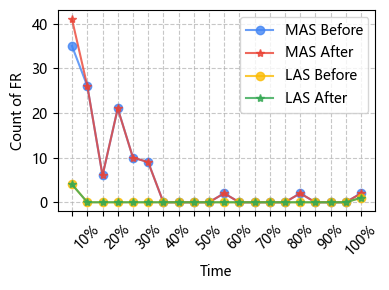

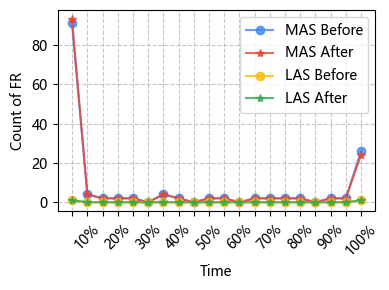

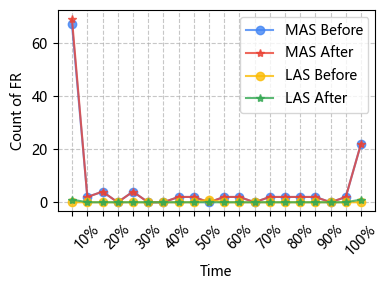

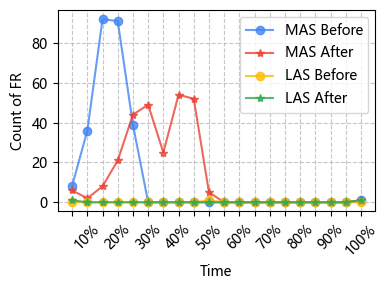

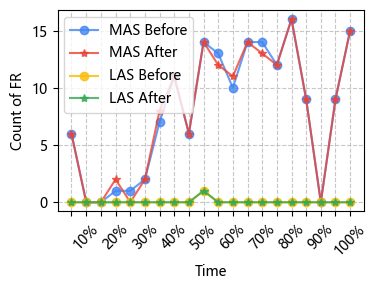

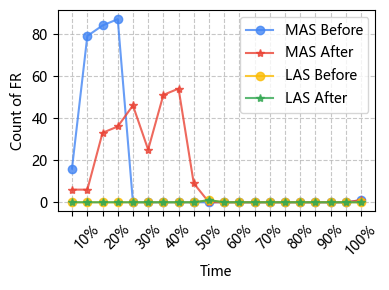

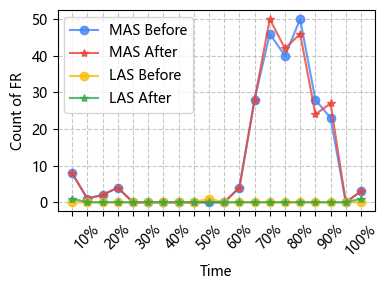

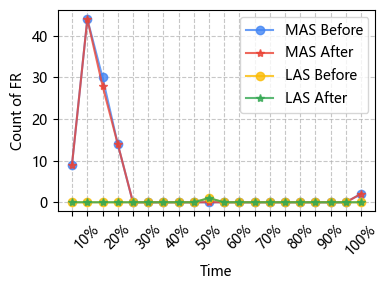

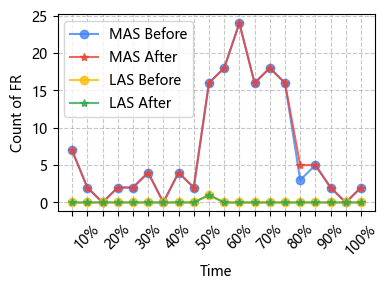

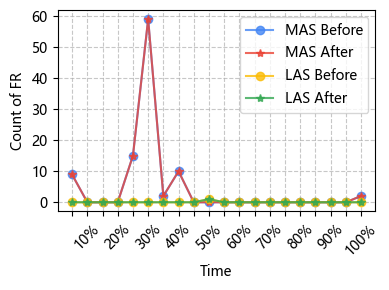

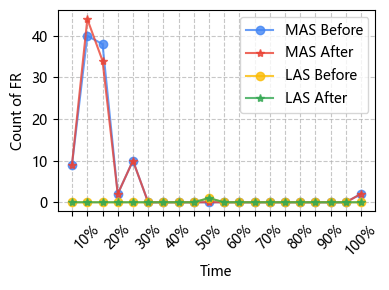

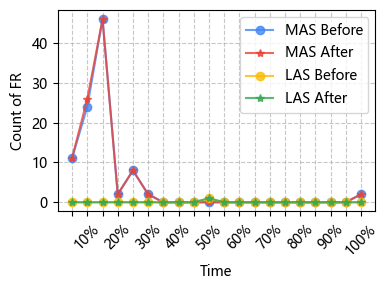

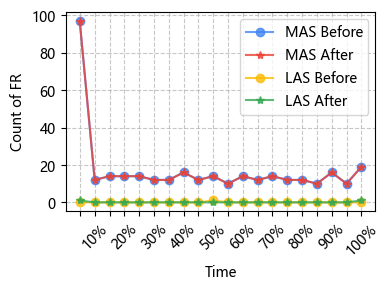

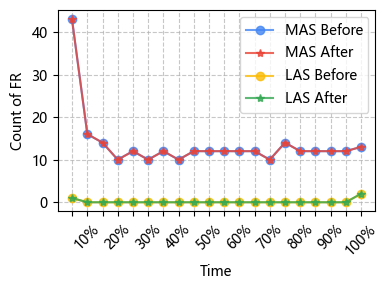

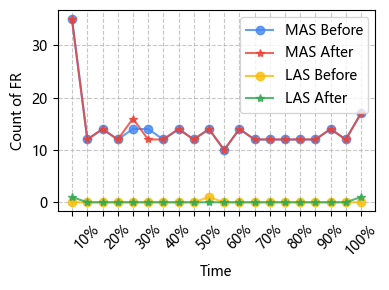

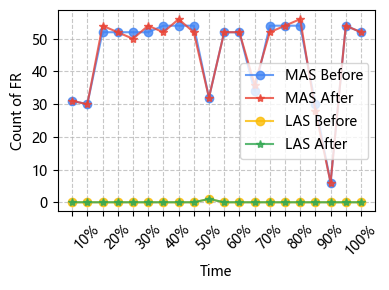

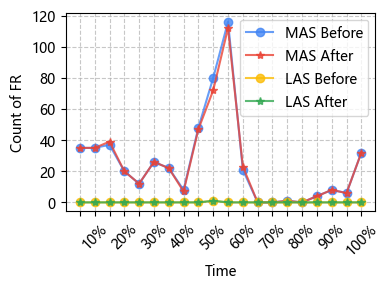

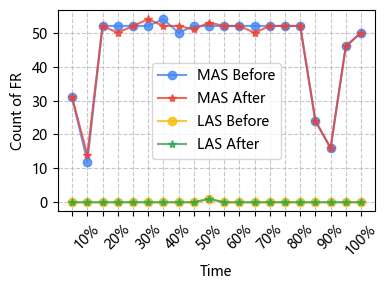

In [90]:
for conn_info in os.listdir(os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'conn_sni')): 
    time_name = conn_info[12:-4] 
    df_meta_td = pd.read_csv(os.path.join(tshark_directory, evaluation_directory, 'tt_fr', 'time_distribution', 'Meta', 'Meta-'+time_name+'.csv')) 
    df_wlan_td = pd.read_csv(os.path.join(tshark_directory, evaluation_directory, 'tt_fr', 'time_distribution', 'WLAN', 'WLAN-'+time_name+'.csv')) 
    df_conn = pd.read_csv(os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'conn_sni', conn_info)) 
    si_meta, si_wlan, sj_meta, sj_wlan = findActiveStreams(df_meta_td, df_wlan_td, df_conn) 
    output_path = os.path.join(tshark_directory, evaluation_directory, 'tt_fr', 'time_distribution', 'figs', conn_info + '.pdf')
    drawFig(si_meta, si_wlan, sj_meta, sj_wlan, output_path)

In [72]:
df_test_meta_time = pd.read_csv(test_meta_time) 
df_test_wlan_time = pd.read_csv(test_wlan_time) 
df_test_conn = pd.read_csv(test_conn) 

In [73]:
max_si = df_test_conn.loc[df_test_conn['W Flows'].idxmax()] 

In [74]:
si_meta_id = max_si['M Stream ID'] 
si_wlan_id = max_si['W Stream ID']

In [75]:
w_i = max_si['W Duration']

In [76]:
filter_1 = df_test_conn.loc[(df_test_conn['W Duration'] >= w_i - 2) & (df_test_conn['W Duration'] <= w_i)]

In [79]:
min_sj = df_test_conn.loc[df_test_conn['W Flows'].idxmin()] 

In [80]:
sj_meta_id = min_sj['M Stream ID'] 
sj_wlan_id = min_sj['W Stream ID']

In [81]:
si_meta_td = df_test_meta_time.loc[df_test_meta_time['StreamID'] == si_meta_id] 
si_wlan_td = df_test_wlan_time.loc[df_test_wlan_time['StreamID'] == si_wlan_id] 

In [82]:
sj_meta_td = df_test_meta_time.loc[df_test_meta_time['StreamID'] == sj_meta_id] 
sj_wlan_td = df_test_wlan_time.loc[df_test_wlan_time['StreamID'] == sj_wlan_id] 

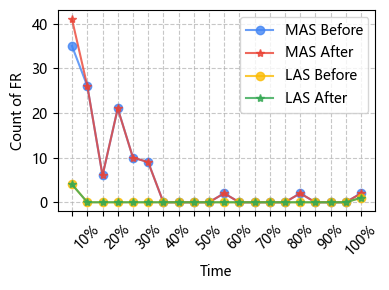

In [83]:
plt.figure(figsize=(4, 3))
plt.rcParams['font.family'] = 'Microsoft YaHei'

bins = 20
time_bins_meta = pd.cut(si_meta_td['Time'], bins=bins) 
time_bins_wlan = pd.cut(si_wlan_td['Time'], bins=bins)
time_bins_sj_meta = pd.cut(sj_meta_td['Time'], bins=bins) 
time_bins_sj_wlan = pd.cut(sj_wlan_td['Time'], bins=bins) 

counts_meta = time_bins_meta.value_counts(sort=False) 
counts_wlan = time_bins_wlan.value_counts(sort=False) 
counts_meta_sj = time_bins_sj_meta.value_counts(sort=False) 
counts_wlan_sj = time_bins_sj_wlan.value_counts(sort=False) 
bin_centers = counts_meta.index.map(lambda interval: interval.mid) 

# 绘制折线图 
plt.plot(bin_centers, counts_meta.values, marker='o', label='MAS Before', color=chrome_blue, alpha=0.8) 
plt.plot(bin_centers, counts_wlan.values, marker='*', label='MAS After', color=chrome_red, alpha=0.8) 
plt.plot(bin_centers, counts_meta_sj.values, marker = 'o', label='LAS Before', color=chrome_yellow, alpha=0.8) 
plt.plot(bin_centers, counts_wlan_sj.values, marker = '*', label='LAS After', color=chrome_green, alpha=0.8) 

plt.xlabel('Time')
plt.xticks()
plt.ylabel('Count of FR')
# plt.title('Flow Changes Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

percentages = np.linspace(5, 100, bins)
visible_percentages = [f'{int(p)}%' if i % 2 == 1 else '' for i, p in enumerate(percentages)]
plt.xticks(bin_centers, visible_percentages, rotation=45) 

# 显示图形
plt.tight_layout()
plt.show()

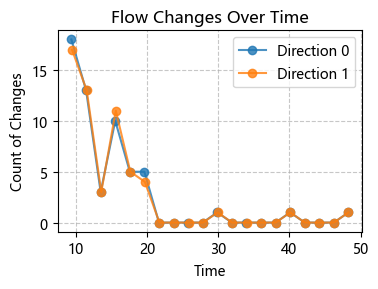

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 是你的 DataFrame
df = si_meta_td
plt.figure(figsize=(4, 3))
plt.rcParams['font.family'] = 'Microsoft YaHei'

# 定义区间
bins = 20

# 分别针对两个方向进行处理
for direction in df['Direction'].unique():
    # 筛选出特定方向的数据
    df_direction = df[df['Direction'] == direction]
    
    # 计算每个时间区间的条目个数
    time_bins = pd.cut(df_direction['Time'], bins=bins)
    counts = time_bins.value_counts(sort=False)
    bin_centers = counts.index.map(lambda interval: interval.mid)

    # 绘制折线图
    plt.plot(bin_centers, counts.values, marker='o', label=f'Direction {direction}', alpha=0.8)

# 添加图例和标签 

plt.xlabel('Time')
plt.ylabel('Count of Changes')
plt.title('Flow Changes Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()
